In [1]:
#general imports
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import os # accessing directory structure

#NLP processing imports
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
import spacy

###Vader Sentiment
#To install vaderSentiment
#!pip install vaderSentiment 
from vaderSentiment import vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

####Lemmatization
from nltk.stem import WordNetLemmatizer
# Lemmatize with POS Tag
from nltk.corpus import wordnet

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
#nltk.download("punkt")

In [3]:
#nltk.download('averaged_perceptron_tagger')

In [4]:
#nltk.download('wordnet')

In [5]:
data = pd.read_csv("twcs.csv")
data.shape

(2811774, 7)

In [6]:
data = data.loc[:10000]
data.shape

(10001, 7)

In [7]:
data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 10001 non-null  int64  
 1   author_id                10001 non-null  object 
 2   inbound                  10001 non-null  bool   
 3   created_at               10001 non-null  object 
 4   text                     10001 non-null  object 
 5   response_tweet_id        6720 non-null   object 
 6   in_response_to_tweet_id  7270 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 478.7+ KB


In [9]:
data["text"] = data["text"].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 10001 non-null  int64  
 1   author_id                10001 non-null  object 
 2   inbound                  10001 non-null  bool   
 3   created_at               10001 non-null  object 
 4   text                     10001 non-null  object 
 5   response_tweet_id        6720 non-null   object 
 6   in_response_to_tweet_id  7270 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 478.7+ KB


# Text Cleaning

In [10]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+|@[^\s]+')
    return url_pattern.sub(r'', text)

data["textclean"] = data["text"].apply(lambda text: remove_urls(text))
data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,textclean
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,I understand. I would like to assist you. We ...
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,I have sent several private messages and no o...
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,Please send us a Private Message so that we c...
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,I did.


In [11]:
top_N = 100 #top 100 words

#convert list of list into text
a = data['textclean'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

In [12]:
data['textclean'].iloc[1]

' and how do you propose we do that'

In [13]:
a

' i understand. i would like to assist you. we would need to get you into a private secured link to further assist.  and how do you propose we do that  i have sent several private messages and no one is responding as usual  please send us a private message so that we can further assist you. just click ‘message’ at the top of your profile.  i did.  can you please send us a private message, so that i can gain further details about your account?  is the worst customer service  this is saddening to hear. please shoot us a dm, so that we can look into this for you. -kc  you gonna magically change your connectivity for me and my whole family ? 🤥 💯  we understand your concerns and we\'d like for you to please send us a direct message, so that we can further assist you. -aa  since i signed up with you....since day 1  h there! we\'d definitely like to work with you on this, how long have you been experiencing this issue? -aa  y’all lie about your “great” connection. 5 bars lte, still won’t load

In [14]:
#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

In [15]:
word_tokens = word_tokenize(b) # Tokenization
filtered_sentence = [w for w in word_tokens if w not in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [16]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]

# Lemmatization

In [17]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
      
    return tag_dict.get(tag, wordnet.NOUN) # tag_dict.get(tag) ,

# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

In [18]:
lemmatized_output = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in cleaned_data_title]
lemmatized_output = [word for word in lemmatized_output if not word.isnumeric()]

# Frequency distribution

In [19]:
word_dist = nltk.FreqDist(lemmatized_output)
top100_words = pd.DataFrame(word_dist.most_common(top_N), columns=['Word','Frequency'])

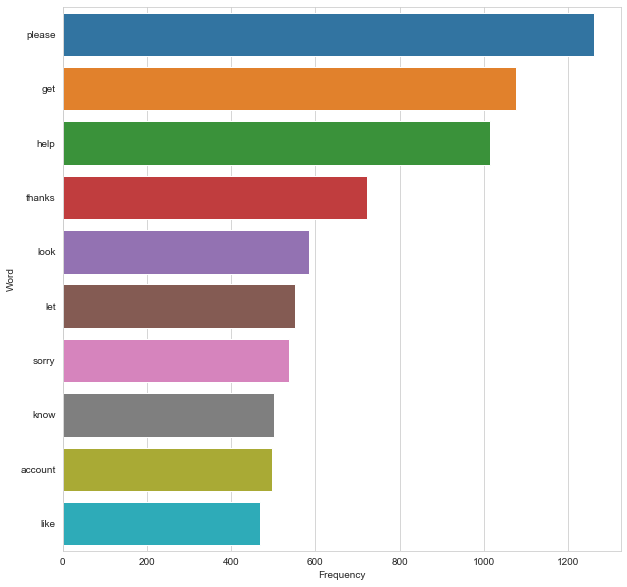

In [20]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Frequency", y="Word", data=top100_words.head(10))

# WordCloud

In [21]:
def wc(data, bgcolor, title):
    plt.figure(figsize=(15,15))
    wc = WordCloud(background_color=bgcolor, max_words=100, max_font_size=50)
    wc.generate(' '.join(data))
    plt.title(title)
    plt.imshow(wc)
    plt.axis('off')

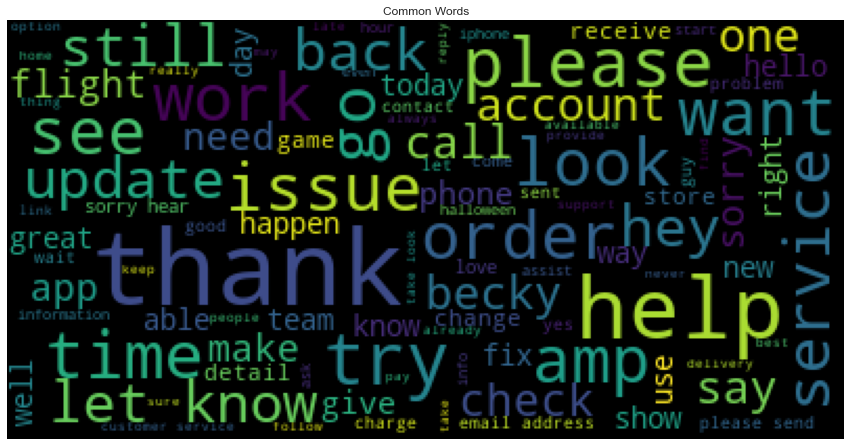

In [22]:
wc(lemmatized_output, 'black', 'Common Words')

# VADER + TEXTBLOB Sentiment Analysis

In [23]:
sent_analyser = SentimentIntensityAnalyzer()
def sentiment(text):
    return sent_analyser.polarity_scores(text)["compound"]

data["Polarity"] = data["textclean"].apply(sentiment)
data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,textclean,Polarity
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,I understand. I would like to assist you. We ...,0.6369
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,0.0000
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,I have sent several private messages and no o...,-0.2960
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,Please send us a Private Message so that we c...,0.4767
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,I did.,0.0000


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 10001 non-null  int64  
 1   author_id                10001 non-null  object 
 2   inbound                  10001 non-null  bool   
 3   created_at               10001 non-null  object 
 4   text                     10001 non-null  object 
 5   response_tweet_id        6720 non-null   object 
 6   in_response_to_tweet_id  7270 non-null   float64
 7   textclean                10001 non-null  object 
 8   Polarity                 10001 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 635.0+ KB


In [25]:
def senti(data):
    if data['Polarity'] >= 0.05:
        val = "Positive"
    elif data['Polarity'] <= -0.05:
        val = "Negative"
    else:
        val = "Neutral"
    return val

data['Sentiment'] = data.apply(senti, axis=1)
data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,textclean,Polarity,Sentiment
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,I understand. I would like to assist you. We ...,0.6369,Positive
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,0.0000,Neutral
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,I have sent several private messages and no o...,-0.2960,Negative
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,Please send us a Private Message so that we c...,0.4767,Positive
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,I did.,0.0000,Neutral


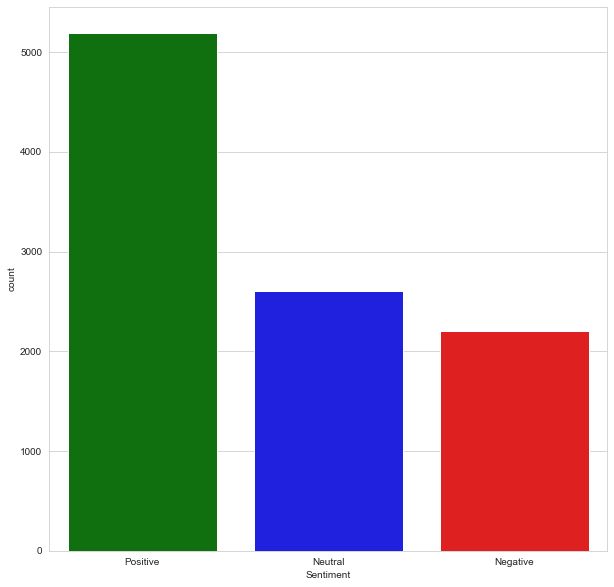

In [26]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment", data=data,
                   palette=dict(Neutral="blue", Positive="Green", Negative="Red"))

# ASPECT MINING/ OPINION MINING

In [27]:
#import spacy
nlp = spacy.load("en_core_web_sm")

In [28]:
def pos(text):
    doc = nlp(text)
    # You want list of Verb tokens 
    aspects = [token.text for token in doc if token.pos_ == "NOUN"]
    return aspects

data["Aspects"] = data["textclean"].apply(pos)
data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,textclean,Polarity,Sentiment,Aspects
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,I understand. I would like to assist you. We ...,0.6369,Positive,[link]
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,0.0000,Neutral,[]
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,I have sent several private messages and no o...,-0.2960,Negative,"[messages, one]"
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,Please send us a Private Message so that we c...,0.4767,Positive,"[Message, Message, top, profile]"
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,I did.,0.0000,Neutral,[]


In [29]:
data.to_excel('twitter_aspect_sentiment.xlsx', index=False)